In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.metrics import dtw_path
from datetime import datetime, timedelta
import os, re, csv, statistics, math
from decimal import Decimal
import bottleneck as bn
from scipy import signal, stats
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import LSTM, Dense
import japanize_matplotlib

2024-05-04 16:35:07.610699: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# モデルの定義
model = Sequential()
model.add(LSTM(units=64, input_shape=(150, 6)))
model.add(Dense(units=5, activation='softmax'))

# モデルのコンパイル
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

2024-05-02 12:16:07.989437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-02 12:16:07.992096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-02 12:16:07.994880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [9]:
#Tobii Pro Glasses 2のデータを読み込む
data = pd.read_csv("Project1_Data_export.csv", header=0)
data[(data['Sensor'] == 'Eye Tracker')] #Eye Trackerのデータを取り出す

,Recording timestamp,Computer timestamp,Sensor,Project name,Export date,Participant name,Recording name,Recording date,Recording date UTC,Recording start time,...,Eye movement type index,Fixation point X,Fixation point Y,Ungrouped,Gyro X,Gyro Y,Gyro Z,Accelerometer X,Accelerometer Y,Accelerometer Z
1,0,766241077,Eye Tracker,Project1,04/22/2024,Participant001,Recording004,04/22/2024,04/22/2024,18:54:16.112,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,19980,766261057,Eye Tracker,Project1,04/22/2024,Participant001,Recording004,04/22/2024,04/22/2024,18:54:16.112,...,1.0,1045.0,502.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,39999,766281076,Eye Tracker,Project1,04/22/2024,Participant001,Recording004,04/22/2024,04/22/2024,18:54:16.112,...,1.0,1045.0,502.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,59975,766301052,Eye Tracker,Project1,04/22/2024,Participant001,Recording004,04/22/2024,04/22/2024,18:54:16.112,...,1.0,1045.0,502.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,79962,766321039,Eye Tracker,Project1,04/22/2024,Participant001,Recording004,04/22/2024,04/22/2024,18:54:16.112,...,1.0,1045.0,502.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150947,611518970,1377760047,Eye Tracker,Project1,04/22/2024,Participant001,Recording004,04/22/2024,04/22/2024,18:54:16.112,...,861.0,805.0,274.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150952,611538951,1377780028,Eye Tracker,Project1,04/22/2024,Participant001,Recording004,04/22/2024,04/22/2024,18:54:16.112,...,861.0,805.0,274.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150957,611558937,1377800014,Eye Tracker,Project1,04/22/2024,Participant001,Recording004,04/22/2024,04/22/2024,18:54:16.112,...,861.0,805.0,274.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150959,611578945,1377820022,Eye Tracker,Project1,04/22/2024,Participant001,Recording004,04/22/2024,04/22/2024,18:54:16.112,...,861.0,805.0,274.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#タイムスタンプをYYYY-MM-DD HH:MM:SS.fff形式に変換
data['Recording start time'] = pd.to_datetime(data['Recording start time'], format='%H:%M:%S.%f')
data['Recording date'] = pd.to_datetime(data['Recording date'], format='%m/%d/%Y')
data['Recording timestamp'] = pd.to_datetime(data['Recording timestamp'], unit='us')
data['True timestamp'] = data['Recording date'] + pd.to_timedelta(data['Recording start time'].dt.strftime('%H:%M:%S.%f')) + pd.to_timedelta(data['Recording timestamp'].dt.strftime('%H:%M:%S.%f'))
data[(data['Sensor'] == 'Eye Tracker')].loc[:,['True timestamp']]

In [35]:
# 条件を満たす行をフィルタリングする
filtered_data = data[(data['Sensor'] == 'Eye Tracker') & (data['Pupil diameter filtered'] > 5.0)]
# 条件を満たす行のTrue timestampを取得する
result_timestamps = filtered_data['True timestamp']

In [ ]:
# グラフの描画領域を設定する
plt.figure(figsize=(20, 5))  # グラフのサイズを設定

# x軸に 'True timestamp' を設定し、y軸に他のカラムを設定してプロットする
plt.plot(data[(data['Sensor'] == 'Eye Tracker')]['True timestamp'], data[(data['Sensor'] == 'Eye Tracker')]['Pupil diameter filtered'], label='Pupil diameter filtered')
plt.plot(data[(data['Sensor'] == 'Eye Tracker')]['True timestamp'], data[(data['Sensor'] == 'Eye Tracker')]['Pupil diameter left'], label='Pupil diameter left')
plt.plot(data[(data['Sensor'] == 'Eye Tracker')]['True timestamp'], data[(data['Sensor'] == 'Eye Tracker')]['Pupil diameter right'], label='Pupil diameter right')

# 特定の範囲のデータを取得
# filtered_data = data[(data['Sensor'] == 'Eye Tracker') & (data['True timestamp'] >= '2024-04-22 19:00:27.000000') & (data['True timestamp'] <= '2024-04-22 19:00:33.000000')]
# x軸に 'True timestamp' を設定し、y軸に他のカラムを設定してプロットする
# plt.plot(filtered_data['True timestamp'], filtered_data['Pupil diameter filtered'], label='Pupil diameter filtered')
# plt.plot(filtered_data['True timestamp'], filtered_data['Pupil diameter left'], label='Pupil diameter left')
# plt.plot(filtered_data['True timestamp'], filtered_data['Pupil diameter right'], label='Pupil diameter right')


# グラフの装飾
plt.xlabel('True timestamp')  # x軸ラベル
plt.ylabel('Value')  # y軸ラベル
plt.title('Pupil diameter')  # グラフタイトル
plt.xticks(rotation=45)  # x軸のラベルを45度回転
plt.grid(True)  # グリッド表示
plt.legend()  # 凡例表示
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S:%f'))

# グラフを表示
plt.tight_layout()  # グラフのレイアウト調整
plt.show()

In [2]:
def process_apple_watch_csv(file_path):
    # CSVファイルの読み込み
    data = pd.read_csv(file_path, header=0, names=['UnixTime', 'AccelerationX', 'AccelerationY', 'AccelerationZ', 'GyroX', 'GyroY', 'GyroZ'])
    # Unixタイムスタンプを日本時間に変換し、タイムゾーン情報を削除して表示する
    data['Timestamp'] = pd.to_datetime(data['UnixTime'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Tokyo').dt.tz_localize(None)
    # 加速度のユークリッドノルムを計算してデータフレームに追加
    data['EuclideanNorm'] = np.sqrt(data['AccelerationX']**2 + data['AccelerationY']**2 + data['AccelerationZ']**2)
    # FFTのサンプル数を取得
    N = len(data)
    # サンプリングレートを定義 (50Hzとする)
    Fs = 50
    # FFT解析を行い、3軸加速度のパワースペクトルを計算してデータフレームに追加
    for axis in ['AccelerationX', 'AccelerationY', 'AccelerationZ', 'EuclideanNorm']:
        accel_fft = np.fft.fft(data[axis])
        power_spectrum = np.abs(accel_fft)**2
        data[f'PowerSpectrum_{axis}'] = power_spectrum

    return data

In [4]:
data = process_apple_watch_csv("acceleration_rotationrate_0.02s_20240415131039.csv")
data2 = process_apple_watch_csv("acceleration_rotationrate_0.02s_20240422190415.csv")
circle1 = process_apple_watch_csv("circle/acceleration_rotationrate_0.02s_20240415130337.csv")
circle2 = process_apple_watch_csv("circle/acceleration_rotationrate_0.02s_20240415130352.csv")
circle3 = process_apple_watch_csv("circle/acceleration_rotationrate_0.02s_20240415130410.csv")
three1 = process_apple_watch_csv("three/acceleration_rotationrate_0.02s_20240415130503.csv")
three2 = process_apple_watch_csv("three/acceleration_rotationrate_0.02s_20240415130510.csv")
three3 = process_apple_watch_csv("three/acceleration_rotationrate_0.02s_20240415130519.csv")

In [52]:
#test = process_apple_watch_csv("motion_data_1714726844.792068.csv")
test = process_apple_watch_csv("/Users/hinase/Downloads/MotionData_20240506_031932.csv")

In [55]:
test['Timestamp'].diff().mean()

Timedelta('0 days 00:00:00.019988552')

In [28]:
test['Timestamp'].diff().sort_values(ascending=False)

38323   0 days 00:00:00.022305280
31973   0 days 00:00:00.021969920
25323   0 days 00:00:00.021883136
10099   0 days 00:00:00.021711872
40538   0 days 00:00:00.021691136
                   ...           
25324   0 days 00:00:00.018308096
10100   0 days 00:00:00.018219264
31974   0 days 00:00:00.018203136
38324   0 days 00:00:00.017509888
0                             NaT
Name: Timestamp, Length: 41836, dtype: timedelta64[ns]

In [18]:
def dist(x, y):
    return (x - y)**2

def get_min(m0, m1, m2, i, j):
    if m0 < m1:
        if m0 < m2:
            return i - 1, j, m0
        else:
            return i - 1, j - 1, m2
    else:
        if m1 < m2:
            return i, j - 1, m1
        else:
            return i - 1, j - 1, m2

In [19]:
def spring(x, y, epsilon):
    Tx = len(x)
    Ty = len(y)

    C = np.zeros((Tx, Ty))
    B = np.zeros((Tx, Ty, 2), int)
    S = np.zeros((Tx, Ty), int)

    C[0, 0] = dist(x[0], y[0])

    for j in range(1, Ty):
        C[0, j] = C[0, j - 1] + dist(x[0], y[j])
        B[0, j] = [0, j - 1]
        S[0, j] = S[0, j - 1]

    for i in range(1, Tx):
        C[i, 0] = dist(x[i], y[0])
        B[i, 0] = [0, 0]
        S[i, 0] = i

        for j in range(1, Ty):
            pi, pj, m = get_min(C[i - 1, j],
                                C[i, j - 1],
                                C[i - 1, j - 1],
                                i, j)
            C[i, j] = dist(x[i], y[j]) + m
            B[i, j] = [pi, pj]
            S[i, j] = S[pi, pj]

        imin = np.argmin(C[:(i+1), -1])
        dmin = C[imin, -1]

        if dmin > epsilon:
            continue

        for j in range(1, Ty):
            if (C[i,j] < dmin) and (S[i, j] < imin):
                break
        else:
            path = [[imin, Ty - 1]]
            temp_i = imin
            temp_j = Ty - 1

            while (B[temp_i, temp_j][0] != 0 or B[temp_i, temp_j][1] != 0):
                path.append(B[temp_i, temp_j])
                temp_i, temp_j = B[temp_i, temp_j].astype(int)

            C[S <= imin] = 100000000
            yield np.array(path), dmin

In [20]:
def plot_spring(data_x, data_y, timestamps, epsilon=0.1):
    pathes = []
    times = []

    for path, cost in spring(data_x, data_y, epsilon):
        plt.figure(figsize=(18, 6))  # グラフを横長にする
        for line in path:
            plt.plot(line, [data_x[line[0]], data_y[line[1]]], linewidth=0.8, c="gray")
        plt.plot(data_x, label='long data')
        plt.plot(data_y, label='gesuture data')


        plt.plot(path[:,0], data_x[path[:,0]], c="C2", label='simular')
        plt.grid(True)  # グリッド表示
        plt.legend()  # 凡例表示
        plt.xticks(rotation=45)  # x軸のラベルを45度回転

        plt.show()
        times.append(timestamps[path[:,0]])
        pathes.append(path)

    return pathes, times

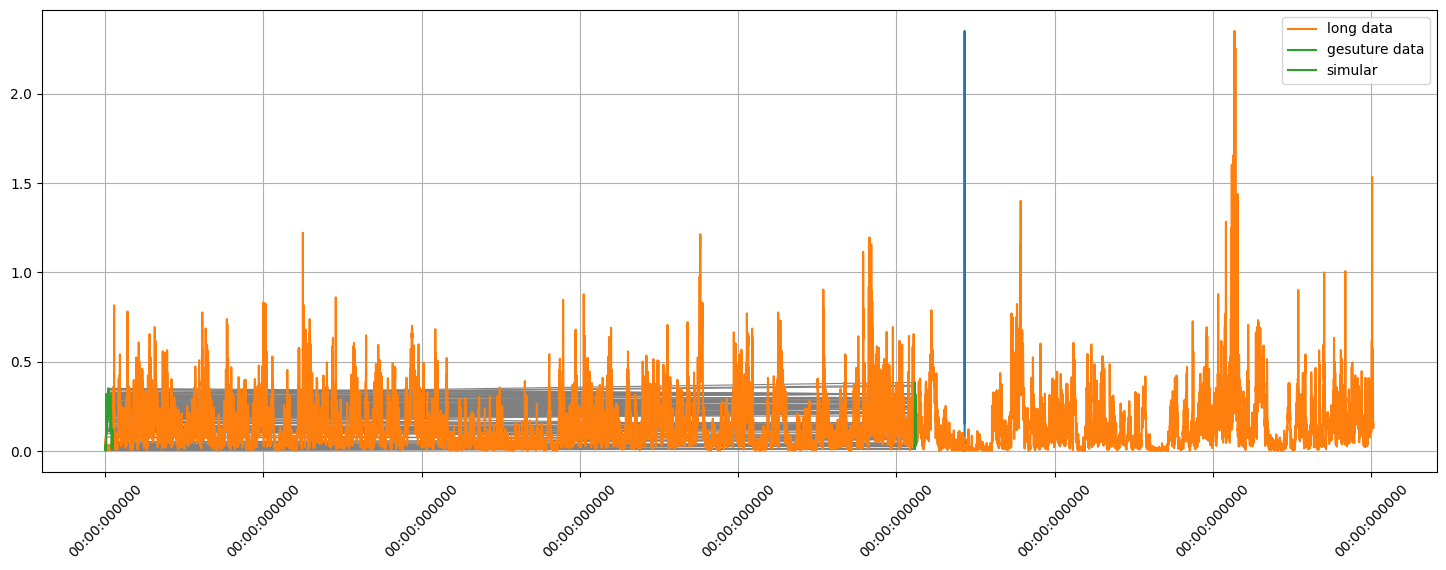

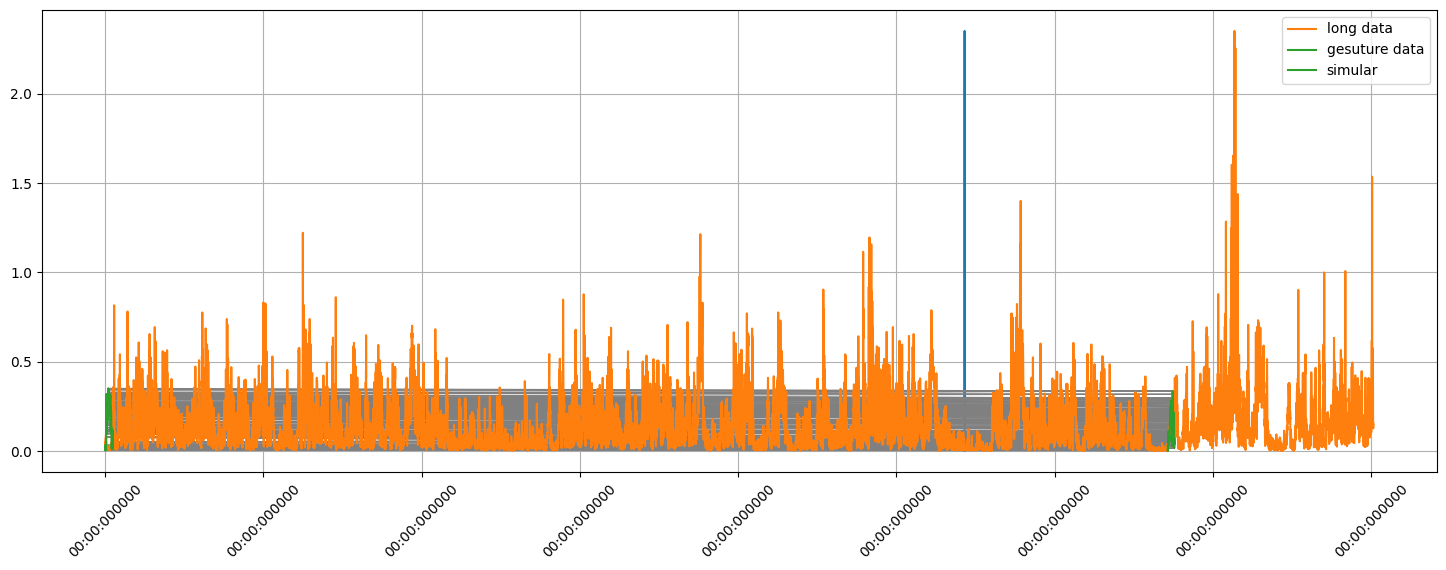

In [21]:
pathes, times = plot_spring(data2['EuclideanNorm'], circle2['EuclideanNorm'], data2['Timestamp'])

In [7]:
data2['Timestamp']

0       2024-04-22 18:54:09.163785984
1       2024-04-22 18:54:09.180164096
2       2024-04-22 18:54:09.195640064
3       2024-04-22 18:54:09.215544064
4       2024-04-22 18:54:09.235703040
                     ...             
29264   2024-04-22 19:03:54.083444224
29265   2024-04-22 19:03:54.103374848
29266   2024-04-22 19:03:54.123409152
29267   2024-04-22 19:03:54.143415808
29268   2024-04-22 19:03:54.163464192
Name: Timestamp, Length: 29269, dtype: datetime64[ns]

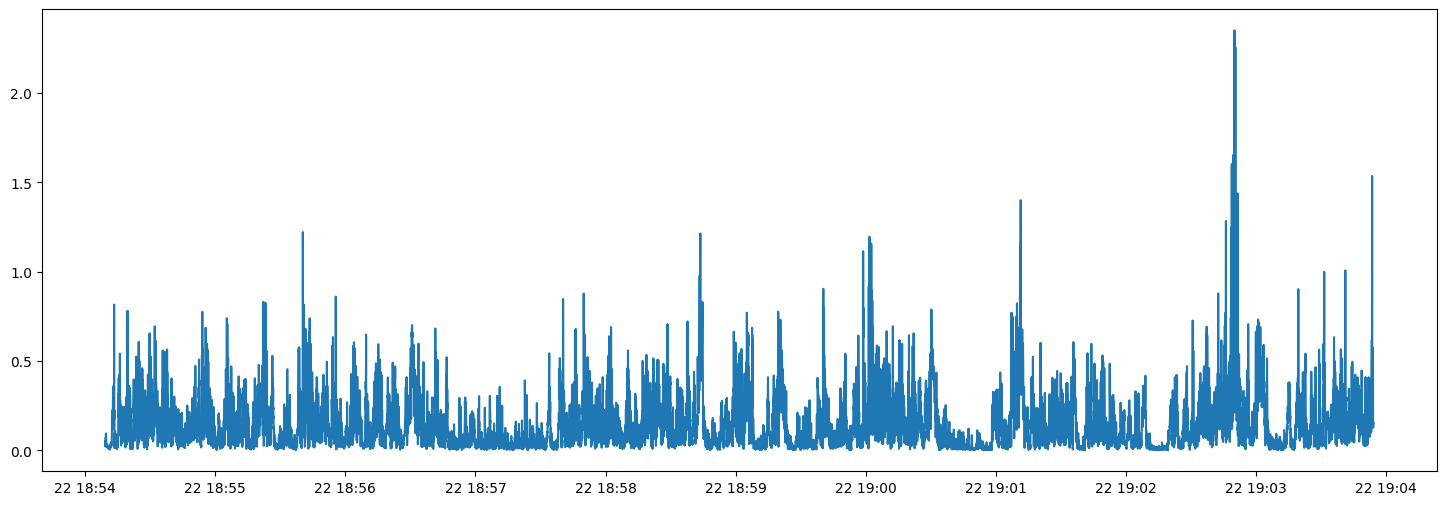

In [15]:
plt.figure(figsize=(18, 6))  # グラフを横長にする
plt.plot(data2['Timestamp'], data2['EuclideanNorm'], label='long data')